In [ ]:
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.layers import Conv2D, concatenate, Subtract,Multiply,Add,MaxPooling2D,UpSampling2D,Lambda
from keras.layers import LeakyReLU
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import EarlyStopping
from PIL import Image
import os
import struct
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imsave
import os.path as osp
import glob
from keras import backend as K

In [ ]:
def LeakyReLU(x, leak=0.1, name="lrelu"):

        f1 = 0.5 * (1.0 + leak)
        f2 = 0.5 * (1.0 - leak)
        return f1 * x + f2 * abs(x)

def read_flow(name):
    f = open(name, "rb")
    data = f.read()
    f.close()
    width = struct.unpack('@i', data[4:8])[0]
    height = struct.unpack('@i', data[8:12])[0]
    flowdata = np.zeros((height, width, 2))
    for i in range(width*height):
        data_u = struct.unpack('@f', data[12+8*i:16+8*i])[0]
        data_v = struct.unpack('@f', data[16+8*i:20+8*i])[0]
        n = int(i / width)
        k = np.mod(i, width)
        flowdata[n, k, :] = [data_u, data_v]
    return flowdata

In [ ]:
h = 320
w = 320
batch_size = 16
epochs = 1
target_size = (h,w,1)
epsilon = 10^(-7)
activation = 'LeakyReLU'

dir_data = '/cyclone_dataset/images'
flow_data = '/cyclone_dataset/flow'
outputs = '/cyclone_dataset/outputs/'

image_list_1 = []
image_list_2 = []
flow_list = []

for sat in os.listdir(dir_data):
    for cyc in os.listdir(osp.join(dir_data, sat)):

        image_list = sorted(glob.glob(osp.join(dir_data, sat, cyc, '*.tif')))
        flow_list1 = sorted(glob.glob(osp.join(flow_data, sat, cyc, '*.flo')))
        for i in range(len(image_list)-1):
            image_list_1.append(image_list[i])
            image_list_2.append(image_list[i+1])
            flow_list.append(flow_list1[i])


imglist1 = np.array(image_list_1)
imglist2 = np.array(image_list_2)
flowlist = np.array(flow_list)

del image_list_1, image_list_2, flow_list

In [ ]:
test_data = '/cyclone_dataset/test'
test_list_1 = []
test_list_2 = []
for cyc in os.listdir(test_data):
  test = sorted(glob.glob(osp.join(test_data, cyc, '*.tif')))

for i in range(len(test)-1):
    test_list_1.append(test[i])
    test_list_2.append(test[i+1])

ll = len(test_list_1)
i1=np.zeros((ll,h,w,1),dtype = float)
i2=np.zeros((ll,h,w,1),dtype = float)
for i in range(ll):
  im = Image.open(test_list_1[i])#, color_mode = "grayscale", target_size = (h,w))
  im = im.convert('L')
  im = im.resize((w,h))
  i1[i,:,:,0] = np.array(im)

  im = Image.open(test_list_2[i])#, color_mode = "grayscale", target_size = (h,w))
  im = im.convert('L')
  im = im.resize((w,h))
  i2[i,:,:,0] = np.array(im)

In [ ]:
import pickle

# Open the file in binary mode
with open('cyclone_dataset/variables/helen_img2.pkl', 'wb') as file:

    # Call load method to deserialze
     pickle.dump(i2,file)



In [ ]:
ll = len(flowlist)
flow_data=np.zeros((ll,h//2,w//2,2),dtype = float)
img1=np.zeros((ll,h,w,1),dtype = float)
img2=np.zeros((ll,h,w,1),dtype = float)
for i in range(ll):
  img = Image.open(imglist1[i])#, color_mode = "grayscale", target_size = (h,w))
  img = img.convert('L')
  img = img.resize((w,h))
  img1[i,:,:,0] = np.array(img)

  img = Image.open(imglist2[i])#, color_mode = "grayscale", target_size = (h,w))
  img = img.convert('L')
  img = img.resize((w,h))
  img2[i,:,:,0] = np.array(img)

  flow1 = read_flow(flowlist[i])
  flow = tf.keras.preprocessing.image.smart_resize(flow1, (h//2, w//2), interpolation='bilinear')
  flow_data[i,:,:,:] = np.array(flow, dtype = 'float32')



In [ ]:
#import pickle

# Open the file in binary mode
with open('/cyclone_dataset/variables/img2.pkl', 'rb') as file:

    # Call load method to deserialze
    img2 = pickle.load(file)

print(img2.shape)

(802, 320, 320, 1)


In [ ]:
def my_net():

    i1 = Input(shape=target_size,name = 'input1')
    i2 = Input(shape=target_size,name = 'input2')
    # it = Subtract()([i2 , i1])

    image = concatenate([i1, i2], axis = 3)
    # image=Input(shape = target_size)
    x = MaxPooling2D(pool_size=(2, 2),padding='same')(image)
    #1
    x = Conv2D(256, kernel_size=(7, 7),activation=activation,padding='same', name = 'layer1')(x)
#    x = LeakyReLU(alpha=0.1)(x)

    #2
    x = Conv2D(256, (5, 5), activation= activation, padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2),padding='same')(x)
    #3
    x = Conv2D(512, (5, 5), activation= activation, padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)

    #4
    x = Conv2D(512, (3,3), activation= activation,padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2),padding='same')(x)
    #5
    x = Conv2D(512, (3,3), activation= activation, padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    #6
    x = Conv2D(512, (3,3), activation= activation ,padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2),padding='same')(x)
    #7
    x = Conv2D(512, (3,3), activation=activation,padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    #8
    x = Conv2D(1024, (1,1), activation=activation,padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2),padding='same')(x)
    #9
    x = Conv2D(512, (3,3), activation=activation,padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)

    #10
    x = Conv2D(512, (5, 5), activation=activation,padding='same', name = 'layer10')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2),padding='same')(x)
    #11
    x = Conv2D(512, (5, 5), activation=activation,padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D(size=(2, 2), data_format=None)(x)
    #12
    x = Conv2D(512, (5, 5), activation=activation,padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D(size=(2, 2), data_format=None)(x)
    #13
    x = Conv2D(512, (5, 5), activation=activation,padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D(size=(2, 2), data_format=None)(x)
    #14
    x = Conv2D(512, (5, 5), activation=activation,padding='same')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D(size=(2, 2), data_format=None)(x)
    #15
    x = Conv2D(2, (5, 5), activation=activation,padding='same',name = 'layer15')(x)
#    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D(size=(2, 2), data_format=None, name = 'flowout')(x)

    my_model = Model(inputs=[i1, i2], outputs=x )

    my_model.compile(loss= 'mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])
    my_model.summary()
    return my_model

my_model = my_net()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 input2 (InputLayer)         [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 320, 320, 2)          0         ['input1[0][0]',              
                                                                     'input2[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 160, 160, 2)          0         ['concatenate[0][0]']     

In [ ]:
history = my_model.fit(x = ([img1, img2]) ,y = flow_data, epochs=40, batch_size = 16,verbose=1)

In [ ]:
%cd '/content/'
import flo2img
plt.imshow(flo2img.flow_to_image(flow_data[1,:,:,:]))

In [ ]:
predictions = my_model.predict(x = ([i1, i2]))

4/4 [==============================] - 45s 324ms/step


In [ ]:
def write_flow(flow, filename):
    f = open(filename, 'wb')
    magic = np.array([202021.25], dtype = np.float32)
    (height, width) = flow.shape[0:2]
    w = np.array([width], dtype = np.int32)
    h = np.array([height], dtype = np.int32)
    magic.tofile(f)
    w.tofile(f)
    h.tofile(f)
    flow.tofile(f)
    f.close()

In [ ]:
for i in range(len(predictions)):
    nameee = str(test_list_1[i])
    outpath1 = outputs + "helen_meteosat_test/" + str(nameee[59:65]) + ".flo"
    write_flow(predictions[i,:,:,:],outpath1)

In [ ]:
def read_flow(name):
    f = open(name, "rb")
    data = f.read()
    f.close()
    width = struct.unpack('@i', data[4:8])[0]
    height = struct.unpack('@i', data[8:12])[0]
    flowdata = np.zeros((height, width, 2))
    for i in range(width*height):
        data_u = struct.unpack('@f', data[12+8*i:16+8*i])[0]
        data_v = struct.unpack('@f', data[16+8*i:20+8*i])[0]
        n = int(i / width)
        k = np.mod(i, width)
        flowdata[n, k, :] = [data_u, data_v]
    return flowdata

In [ ]:
print(outpath1)
flow = read_flow(outpath1)
plt.imshow(flo2img.flow_to_image(flow))

In [ ]:
for i in range(len(predictions)):
    plt.imshow(flo2img.flow_to_image(predictions[i,:,:,:]))
    nameee = str(imglist1[i])
    plt.axis('off')
    plt.savefig(ouptuts + str(nameee[62:68]) + ".png" , bbox_inches = 'tight', pad_inches = 0)


In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p '/cyclone_dataset/outputs/saved_model'
my_model.save('/cyclone_dataset/outputs/saved_model/my_model')

In [ ]:
# my_model directory
!ls '/cyclone_dataset/outputs/saved_model'

# Contains an assets folder, saved_model.pb, and variables folder.
!ls '/cyclone_dataset/outputs/saved_model/my_model'

new_model = tf.keras.models.load_model('/cyclone_dataset/outputs/saved_model/my_model')

# Check its architecture
new_model.summary()

# Evaluate the restored model
#loss, acc = new_model.evaluate(x = ([img1[:32], img2[:32]]), flow_data[:32,:,:,:], verbose=2)
#print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

#print(new_model.predict(img1[:16]).shape)

In [ ]:
def vortex_disp(flow, image1, df, i):

    u = flow[:,:,0]
    v = flow[:,:,1]

    tu = df[:,:,0]  #cv2.resize(df[:,:,0], (w//2,h//2))
    tv = df[:,:,1] #cv2.resize(df[:,:,1], (w//2,h//2))

    image = cv2.resize(image1, (w//2,h//2))

    # --- Compute flow magnitude
    norm = np.sqrt(u ** 2 + v ** 2)
    nameee = str(imglist1[i])
    # --- Display
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16,12))

    # # --- Sequence image sample

    ax0.imshow(flo2img.flow_to_image(df))
    ax0.set_title("mwetkf output")
    ax0.set_axis_off()

    # --- Quiver plot arguments

    nvec = 25 # Number of vectors to be displayed along each image dimension
    nl, nc = image.shape
    step = max(nl//nvec, nc//nvec)

    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = tu[::step, ::step]
    v_ = tv[::step, ::step]

    ax1.imshow(image,'gray')
    ax1.quiver(x, y, u_, v_, color='r', units='dots',
               angles='xy', scale_units='xy', lw=1)
    # ax1.set_title("Optical flow magnitude and vector field")
    ax1.set_axis_off()

    ax2.imshow(flo2img.flow_to_image(flow))
    ax2.set_title("Train - 40 epochs(bs - 16)")
    ax2.set_axis_off()
    fig.tight_layout()

    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = u[::step, ::step]
    v_ = v[::step, ::step]

    ax3.imshow(image,'gray')
    ax3.quiver(x, y, u_, v_, color='r', units='dots',
               angles='xy', scale_units='xy', lw=1)
    ax3.set_title("hudhud - %06s" %str(nameee[62:68]))
    ax3.set_axis_off()



    #fig.savefig(ouptuts + "hudhud/"+ str(nameee[62:68]) + ".png" , bbox_inches = 'tight', pad_inches = 0)

    plt.show()

In [ ]:
import cv2
for i in range(len(predictions)):
    vortex_disp(predictions[i,:,:,:], i1[i,:,:,0], flow_data[i,:,:,:], i)


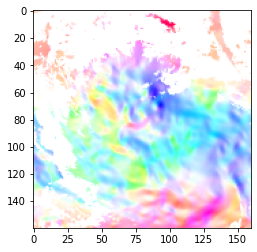

In [ ]:
import flo2img
i = 1
plt.imshow(flo2img.flow_to_image(flow_data[i,:,:,:]))

In [ ]:
print(len(flow_data))

802
